In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Note: The following do not work with Python 3.12
import shap
from ydata_profiling import ProfileReport
import sweetviz as sv

Reproducibility:

In [3]:
seed = 2024

# pandas, statsmodels, matplotlib and y_data_profiling rely on numpy's random generator, and thus, we need to set the seed in numpy
np.random.seed(seed)

In [4]:
diet = pd.read_csv('diet.csv', low_memory=False)
requests = pd.read_csv('requests.csv', low_memory=False)
reviews = pd.read_csv('reviews.csv', low_memory=False)
reviews['Rating'].unique()

array([ 2., nan])

Changing the object data types

In [5]:
diet['Diet'] = diet['Diet'].astype('category')
requests['HighProtein'] = requests['HighProtein'].astype('category')
requests['LowSugar'] = requests['LowSugar'].astype('category')

Data Joining using common attributes

In [6]:
author_ID = 'AuthorId'
merged_diet_requests = pd.merge(diet, requests, on=author_ID, how='left')
merged_diet_requests

,AuthorId,Diet,Age,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
0,10000120E,Vegetarian,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000014D,Vegan,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000015A,Vegetarian,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000016E,Vegetarian,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000027E,Vegan,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
362749,999917E,Vegetarian,28,169413.0,3600.387748,0.0,Indifferent,0.0,Indifferent,0.0
362750,999936C,Omnivore,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362751,99993D,Vegetarian,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362752,99994A,Vegetarian,18,373964.0,7199.509521,0.0,Yes,0.0,0,0.0


In [7]:
merged_diet_requests.to_csv('merged_diet_requests.csv')

Impute the missing values

In [8]:
merged_diet_requests['Diet'] = merged_diet_requests['Diet'].fillna('Vegetarian')
merged_diet_requests_cleaned = merged_diet_requests.dropna(subset=['RecipeId'])
merged_diet_requests_cleaned

,AuthorId,Diet,Age,RecipeId,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber
6,1000036C,Vegetarian,50,320576.0,119.024930,0.0,Indifferent,0.0,Indifferent,1.0
14,1000216B,Vegetarian,78,189335.0,1199.386790,0.0,Yes,0.0,0,1.0
16,1000221A,Vegetarian,25,133043.0,362.152341,0.0,Yes,0.0,Indifferent,1.0
17,1000221A,Vegetarian,25,90537.0,1198.957497,0.0,Yes,0.0,0,1.0
18,1000221A,Vegetarian,25,334314.0,5400.036634,1.0,Indifferent,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
362736,999774A,Vegetarian,57,29002.0,2402.372535,0.0,Indifferent,0.0,Indifferent,0.0
362737,999774A,Vegetarian,57,159252.0,5999.598903,0.0,Yes,0.0,0,0.0
362738,999774A,Vegetarian,57,1171.0,480.233207,1.0,Yes,0.0,0,0.0
362749,999917E,Vegetarian,28,169413.0,3600.387748,0.0,Indifferent,0.0,Indifferent,0.0


Merge the file with reviews column to include 'likes' column

In [9]:
merged_data = merged_diet_requests_cleaned.merge(reviews, how='inner', on='AuthorId')
merged_data

,AuthorId,Diet,Age,RecipeId_x,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,RecipeId_y,Rating,Like,TestSetId
0,1000036C,Vegetarian,50,320576.0,119.024930,0.0,Indifferent,0.0,Indifferent,1.0,320576,NaN,False,NaN
1,1000216B,Vegetarian,78,189335.0,1199.386790,0.0,Yes,0.0,0,1.0,189335,NaN,False,NaN
2,1000221A,Vegetarian,25,133043.0,362.152341,0.0,Yes,0.0,Indifferent,1.0,133043,2.0,False,NaN
3,1000221A,Vegetarian,25,133043.0,362.152341,0.0,Yes,0.0,Indifferent,1.0,90537,2.0,False,NaN
4,1000221A,Vegetarian,25,133043.0,362.152341,0.0,Yes,0.0,Indifferent,1.0,334314,2.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7926874,999774A,Vegetarian,57,1171.0,480.233207,1.0,Yes,0.0,0,0.0,29002,2.0,False,NaN
7926875,999774A,Vegetarian,57,1171.0,480.233207,1.0,Yes,0.0,0,0.0,159252,NaN,False,NaN
7926876,999774A,Vegetarian,57,1171.0,480.233207,1.0,Yes,0.0,0,0.0,1171,2.0,True,NaN
7926877,999917E,Vegetarian,28,169413.0,3600.387748,0.0,Indifferent,0.0,Indifferent,0.0,169413,2.0,False,NaN


Data Visualization

Diet

In [10]:
# load the data
file_path = "diet.csv"
df = pd.read_csv(file_path)

In [11]:
# have a look at the data and its attributes
print(df.sample(10))

           AuthorId        Diet  Age
168659     2207556C  Vegetarian   74
206750      338571E  Vegetarian   36
4498       1063960D  Vegetarian   23
183825     2552022E       Vegan   33
177513      240154D  Vegetarian   28
16133      1222204E    Omnivore   64
23656      1324508B       Vegan   71
173830     2321250B    Omnivore   35
239673      620403B    Omnivore   67
146412  2002298125D  Vegetarian   41


In [14]:
# get a general overview over data, check for missing values, etc.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271907 entries, 0 to 271906
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   AuthorId  271907 non-null  object
 1   Diet      271906 non-null  object
 2   Age       271907 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ MB
None


                 Age
count  271907.000000
mean       48.503727
std        17.898130
min        18.000000
25%        33.000000
50%        48.000000
75%        64.000000
max        79.000000


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


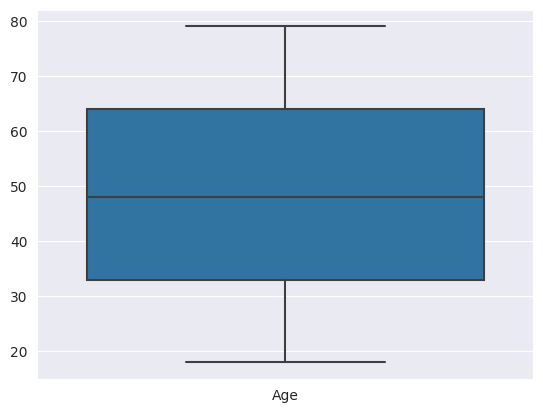

In [15]:
# have a look at common statistics of the dataset
print(df.describe())
sns.boxplot(df);

In [17]:
# check the balancing of classes/labels
print(df.groupby("Diet").size())

Diet
Omnivore       78626
Vegan          49897
Vegetarian    143383
dtype: int64


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


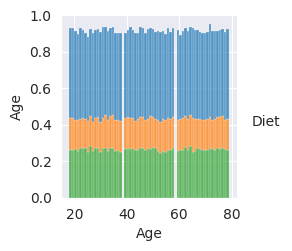

In [18]:
# have a look at the feature distributions with a pairplot,
# as it gives you a good overview over possible outliers
# and a good overview over the data in general

# pairplot for the full data
sns.pairplot(df, hue="Diet", diag_kind="hist", diag_kws={"multiple" : "stack"});

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_c

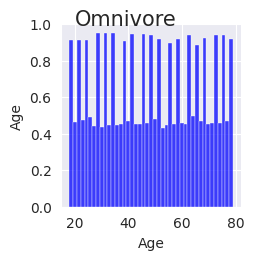

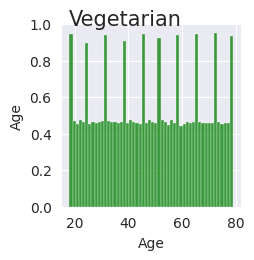

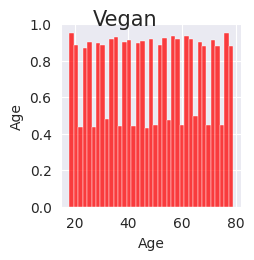

In [21]:
# look at class-dependent pairplots
df_grouped_by_class = df.groupby(by="Diet")

df_omnivore = df_grouped_by_class.get_group("Omnivore")
df_vegetarian = df_grouped_by_class.get_group("Vegetarian")
df_vegan = df_grouped_by_class.get_group("Vegan")

class_labels = {
    "Omnivore" : {
        "color" : "blue",
        "data" : df_omnivore
    },
    "Vegetarian" : {
        "color" : "green",
        "data" : df_vegetarian
    },
    "Vegan" : {
        "color" : "red",
        "data" : df_vegan
    }
}

for class_i in class_labels:
    class_color = class_labels[class_i]["color"]
    class_df = class_labels[class_i]["data"]
    p = sns.pairplot(class_df, diag_kind="hist", diag_kws={"color" : class_color}, plot_kws={"color" : class_color, "label" : class_i})
    p.fig.suptitle(class_i, y=1.0, size=15)

                                             |          | [  0%]   00:00 -> (? left)


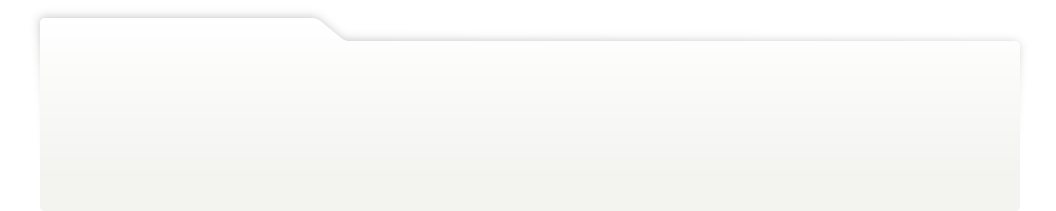
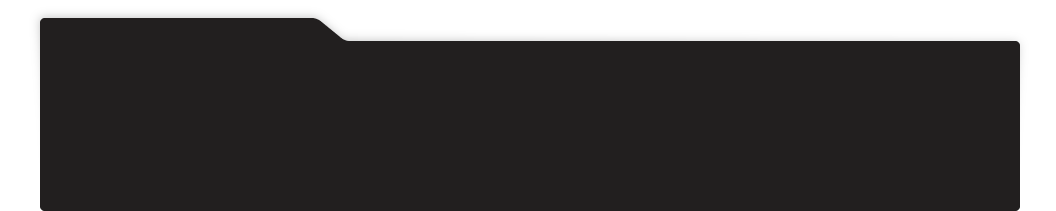
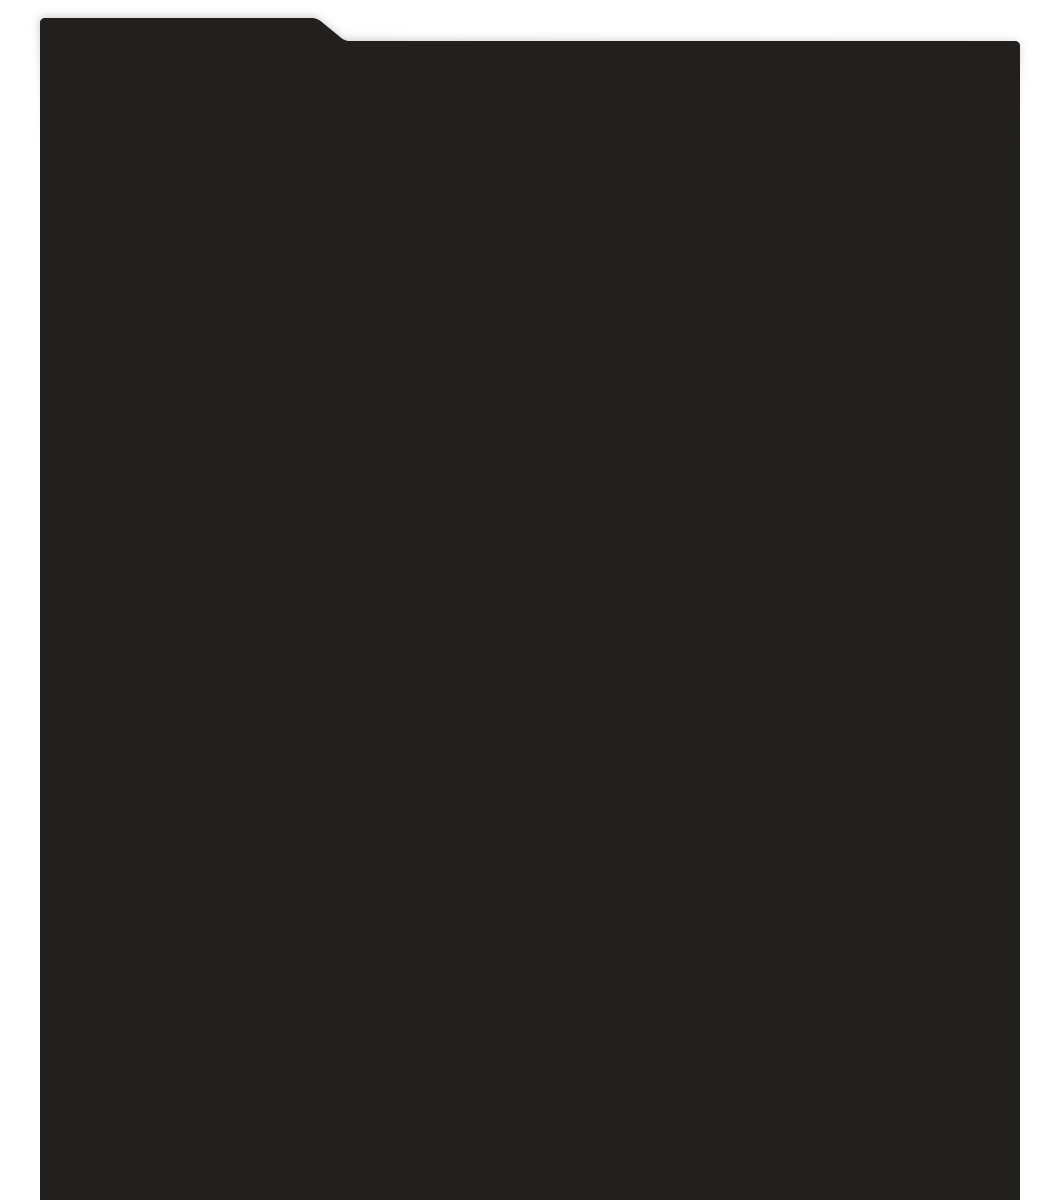
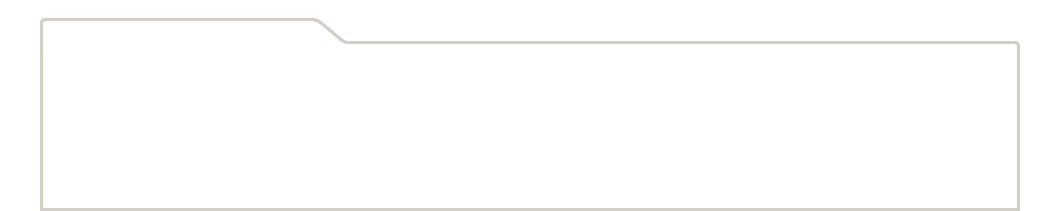
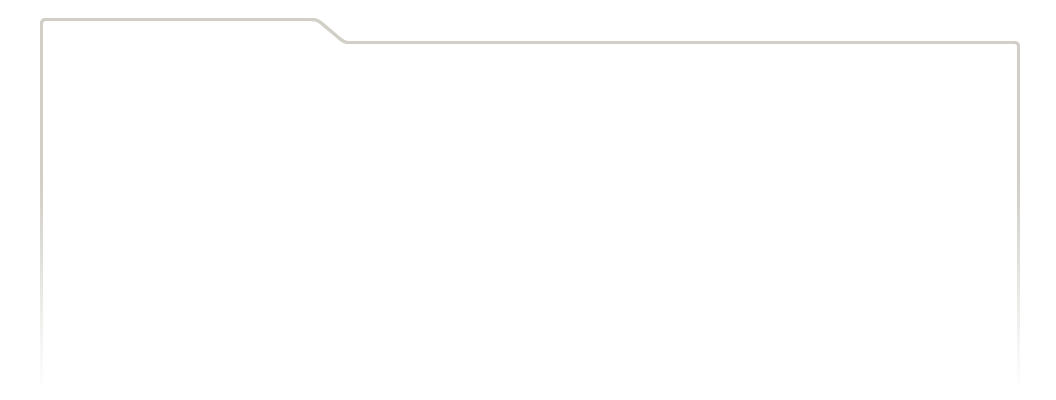
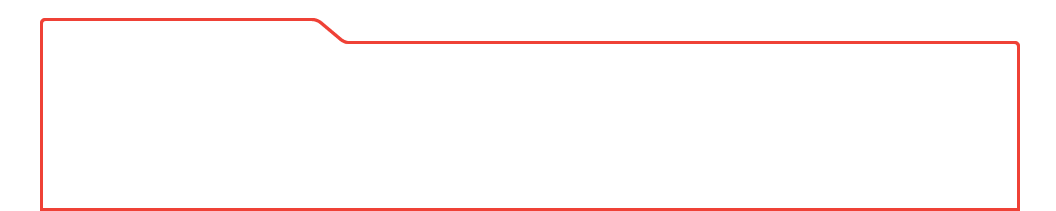
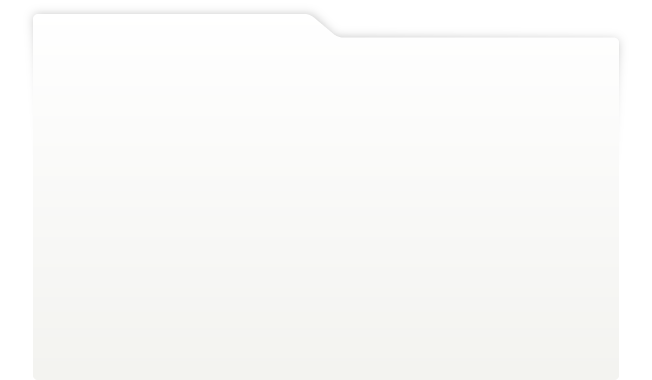
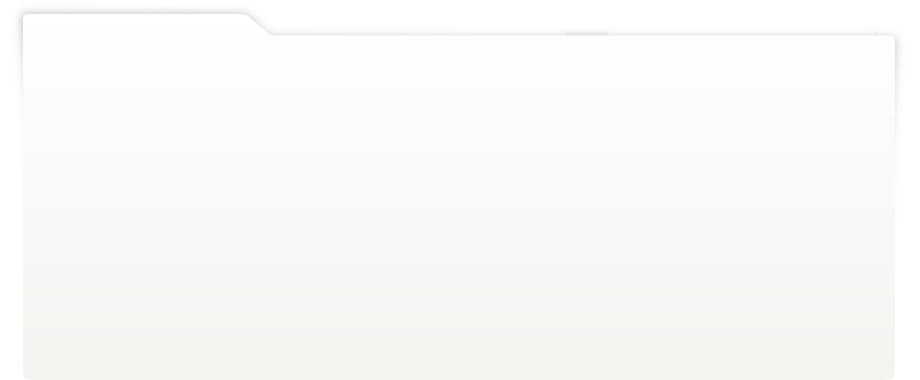
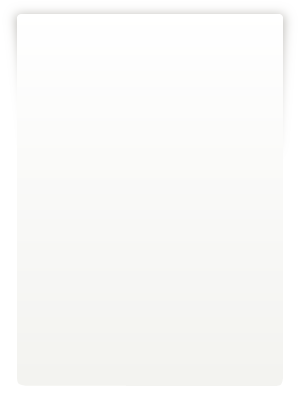
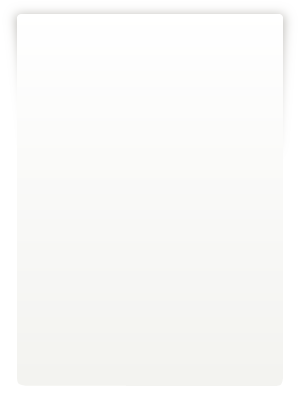
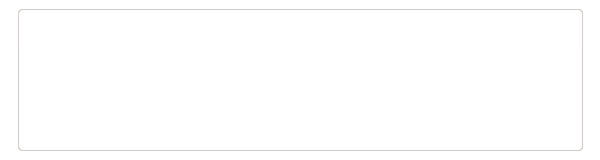
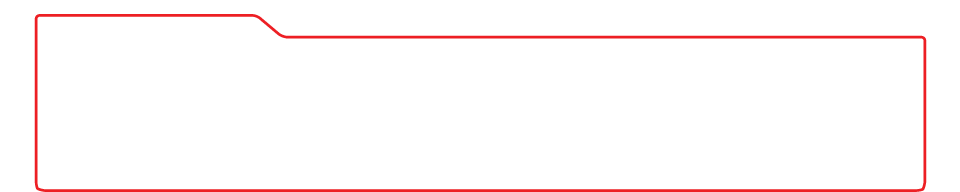
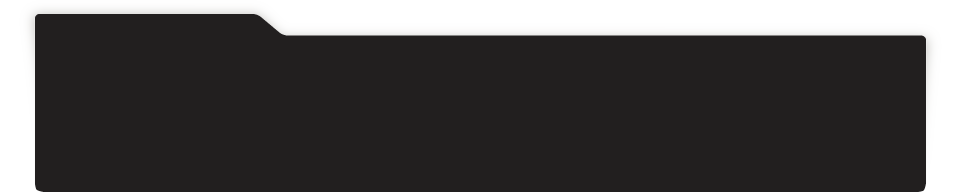
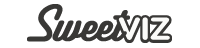
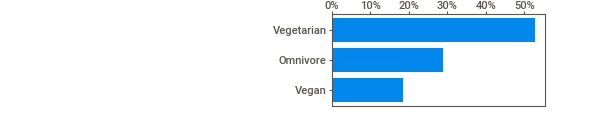
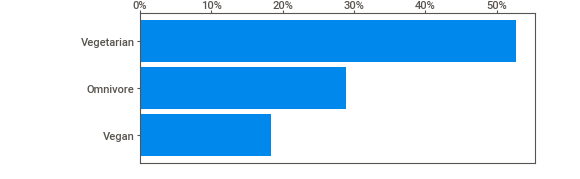
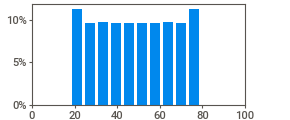
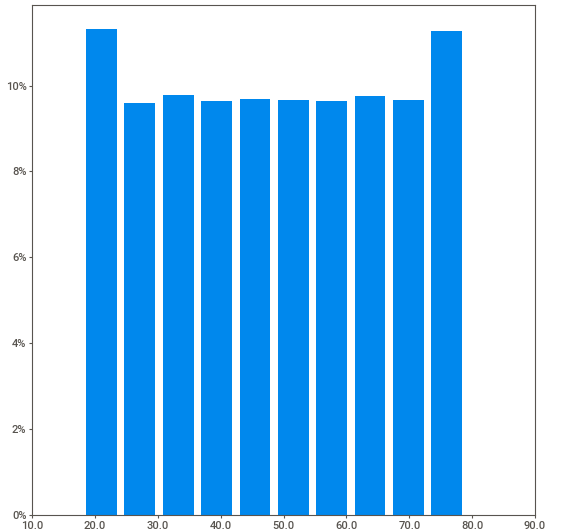
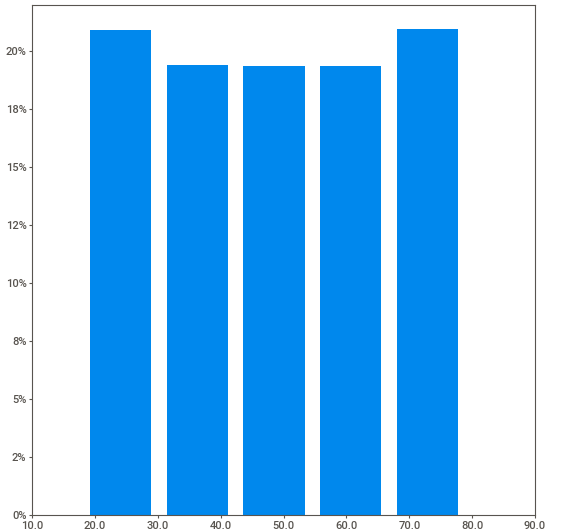
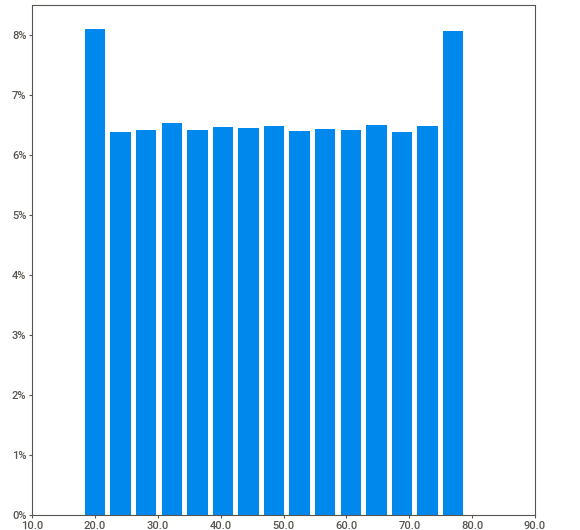
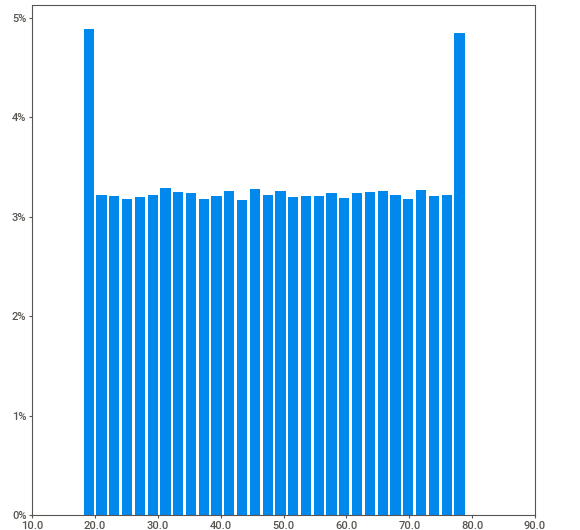
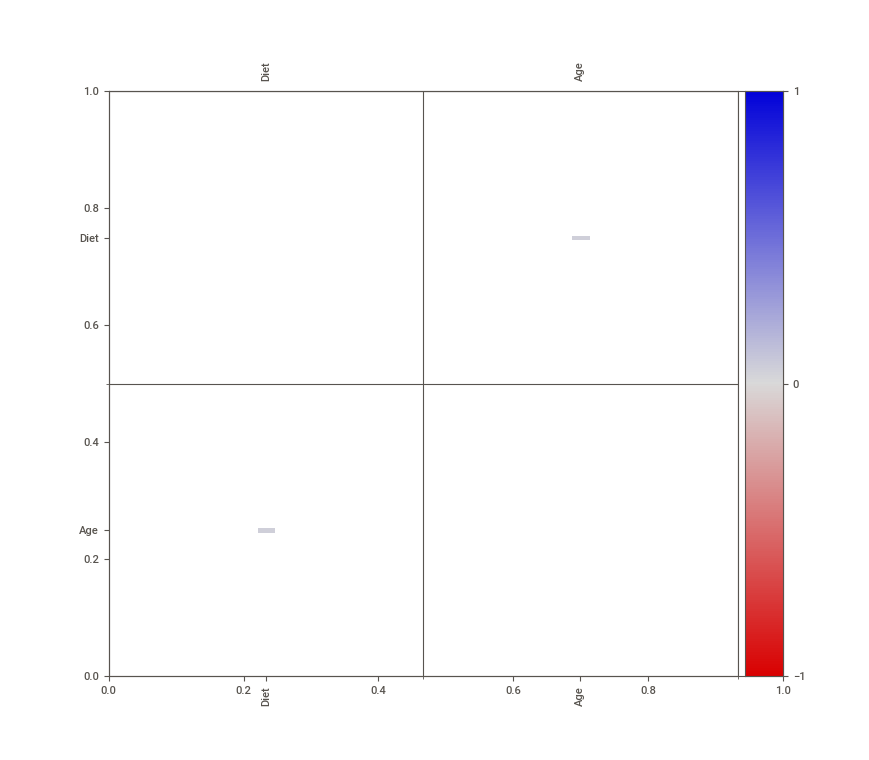
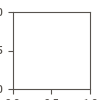

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# We can also leverage the dataprep package to get a nice summary report
report = sv.analyze(df)
report.show_notebook()

# We can also leverage the yadata_profiling package to get a nice summary report
profile = ProfileReport(df, title="Diet Data - Summary Report")
profile

Reviews

In [24]:
# load the data
file_path = "reviews.csv"
df = pd.read_csv(file_path)

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


In [25]:
# have a look at the data and its attributes
print(df.sample(10))

           AuthorId  RecipeId  Rating   Like  TestSetId
62407        17708E       992     2.0  False        NaN
80855   2001062047A    351459     2.0  False        NaN
30085       518537E    184938     2.0    NaN    30086.0
132310      751444B    429987     2.0  False        NaN
27286      1835992B     23775     NaN    NaN    27287.0
92146   2002061544D     67549     2.0  False        NaN
75007   2000278026A    494972     2.0  False        NaN
84263   2001375990D    370707     2.0  False        NaN
41546   2001670708B    117780     NaN    NaN    41547.0
115889      343561E    461088     NaN  False        NaN


In [26]:
# get a general overview over data, check for missing values, etc.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140195 entries, 0 to 140194
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AuthorId   140195 non-null  object 
 1   RecipeId   140195 non-null  int64  
 2   Rating     77108 non-null   float64
 3   Like       97381 non-null   object 
 4   TestSetId  42814 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.3+ MB
None


            RecipeId   Rating     TestSetId
count  140195.000000  77108.0  42814.000000
mean   152770.642477      2.0  21407.500000
std    130325.801041      0.0  12359.481549
min        40.000000      2.0      1.000000
25%     47111.000000      2.0  10704.250000
50%    109423.000000      2.0  21407.500000
75%    232075.000000      2.0  32110.750000
max    541195.000000      2.0  42814.000000


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


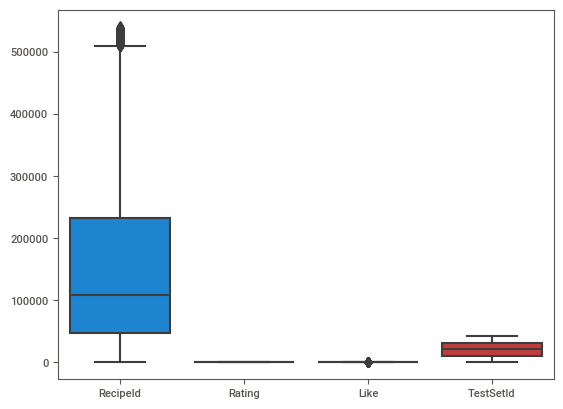

In [27]:
# have a look at common statistics of the dataset
print(df.describe())
sns.boxplot(df);

In [29]:
# check the balancing of classes/labels
print(df.groupby("Rating").size())

Rating
2.0    77108
dtype: int64


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

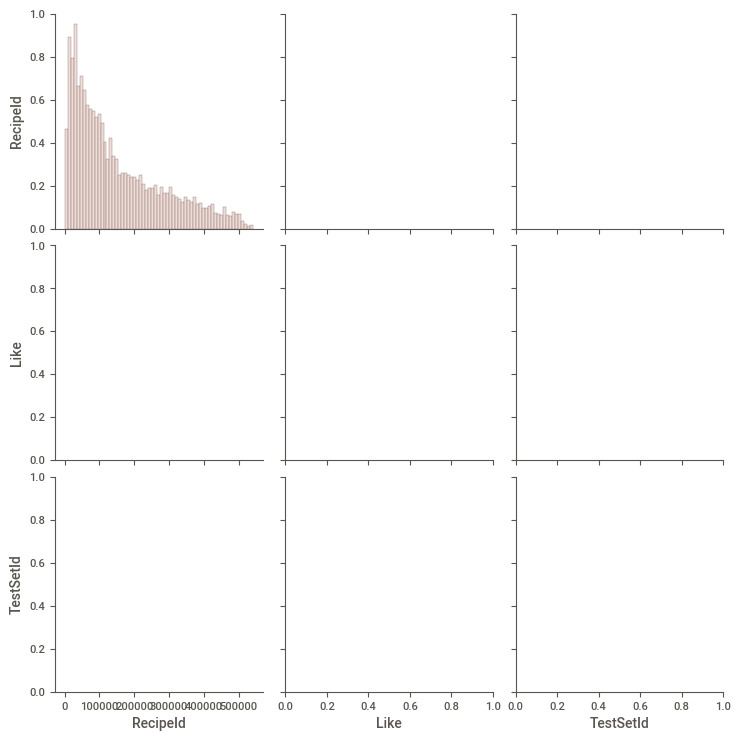

In [30]:
# have a look at the feature distributions with a pairplot,
# as it gives you a good overview over possible outliers
# and a good overview over the data in general

# pairplot for the full data
sns.pairplot(df, hue="Rating", diag_kind="hist", diag_kws={"multiple" : "stack"});

In [ ]:
# look at class-dependent pairplots
# df_grouped_by_class = df.groupby(by="variety")

# df_setosa = df_grouped_by_class.get_group("Setosa")
# df_versicolor = df_grouped_by_class.get_group("Versicolor")
# df_virginica = df_grouped_by_class.get_group("Virginica")

# class_labels = {
#    "Setosa" : {
 #       "color" : "blue",
  #      "data" : df_setosa
   # },
#    "Versicolor" : {
#        "color" : "green",
#        "data" : df_versicolor
#    },
#    "Virginica" : {
#        "color" : "red",
#        "data" : df_virginica
#    }
#}

#for class_i in class_labels:
#    class_color = class_labels[class_i]["color"]
#    class_df = class_labels[class_i]["data"]
#    p = sns.pairplot(class_df, diag_kind="hist", diag_kws={"color" : class_color}, plot_kws={"color" : class_color, "label" : class_i})
#    p.fig.suptitle(class_i, y=1.0, size=15)

                                             |          | [  0%]   00:00 -> (? left)

The behavior of is_bool_dtype with an object-dtype Index of bool objects is deprecated. In a future version, this will return False. Cast the Index to a bool dtype instead.



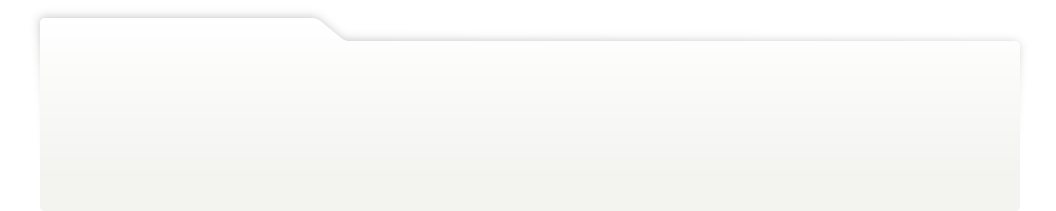
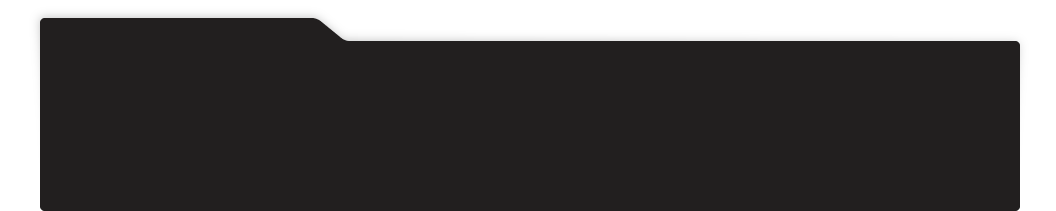
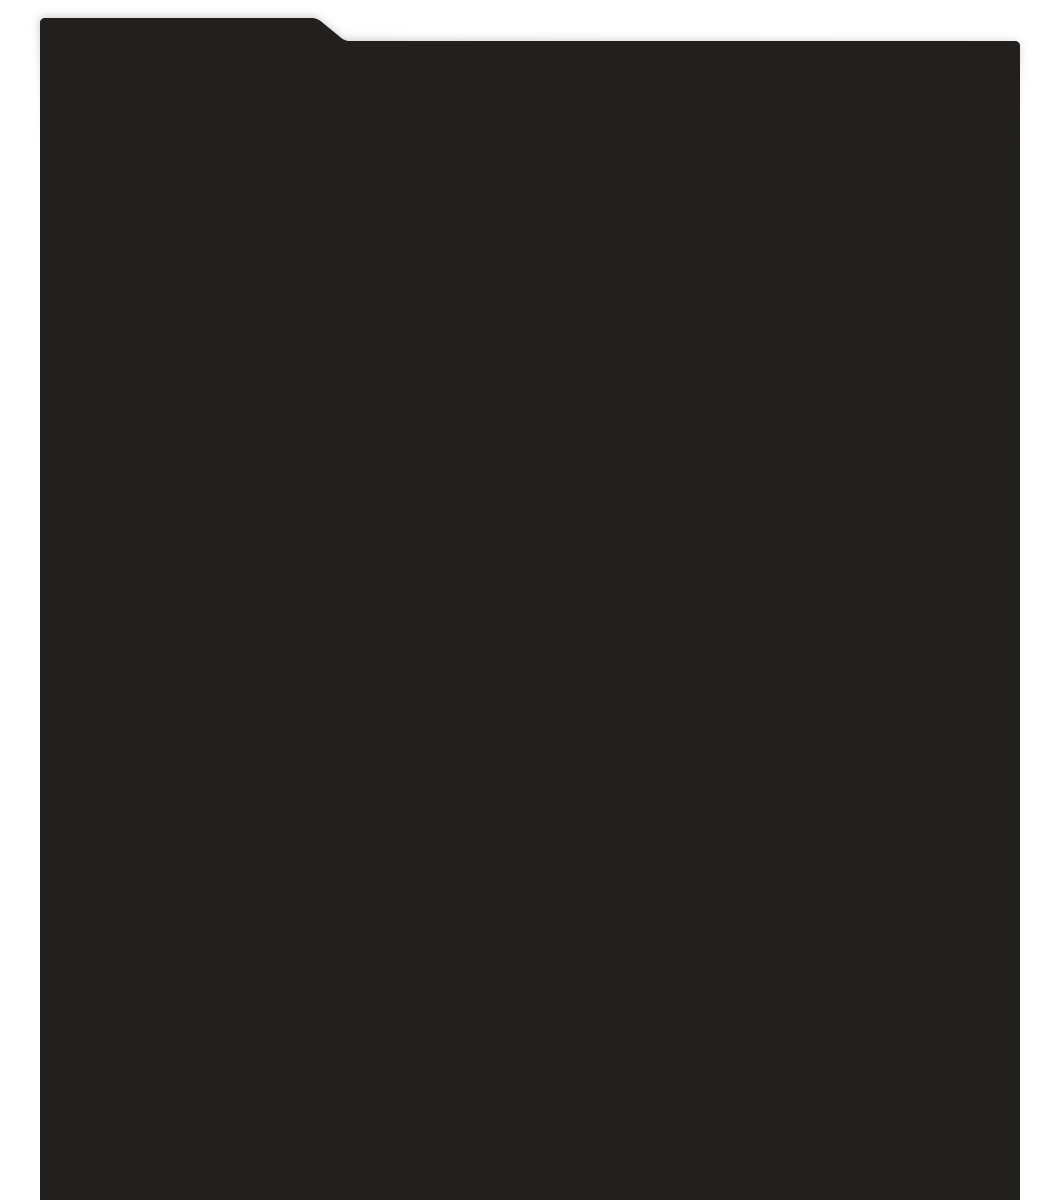
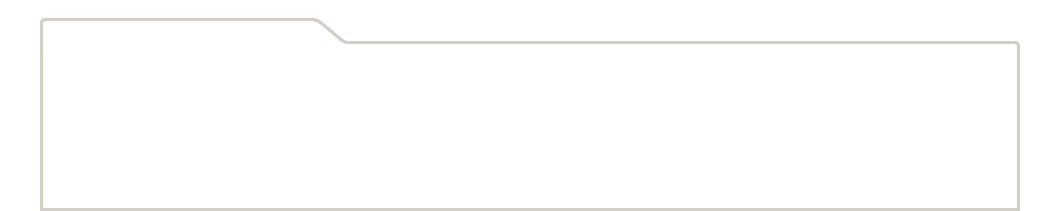
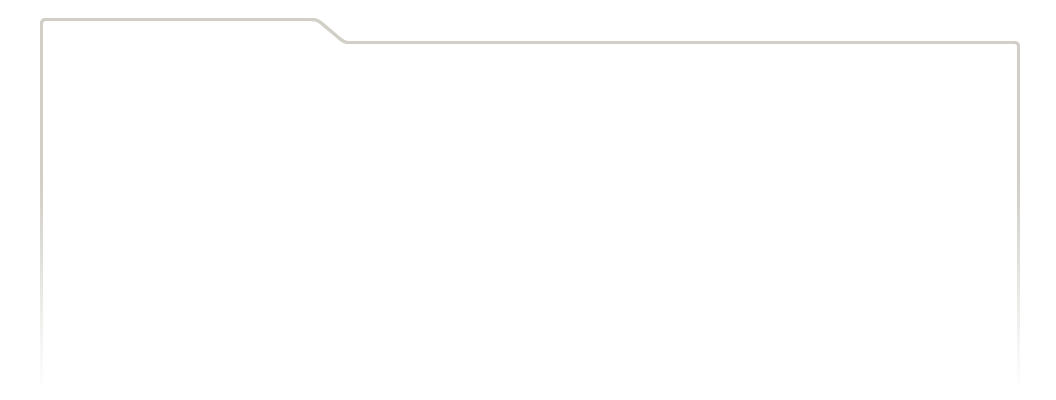
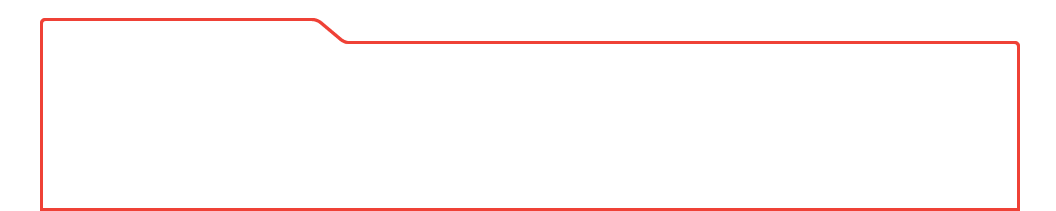
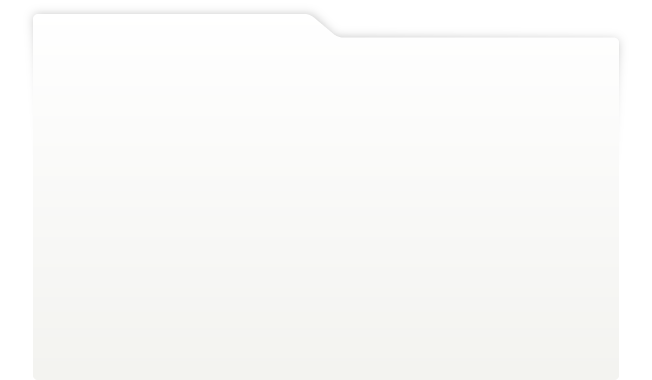
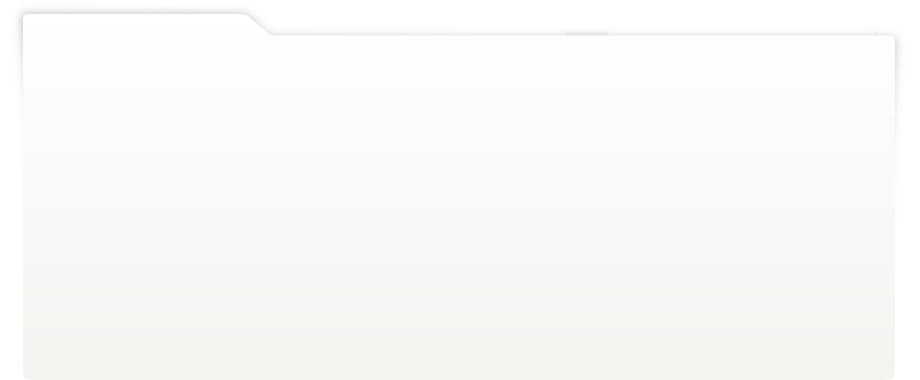
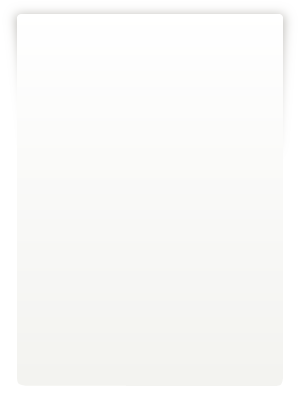
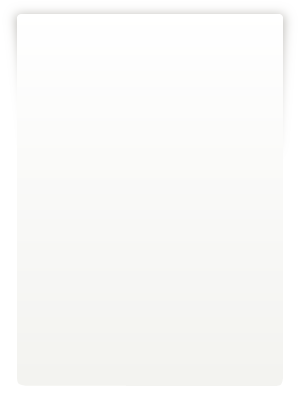
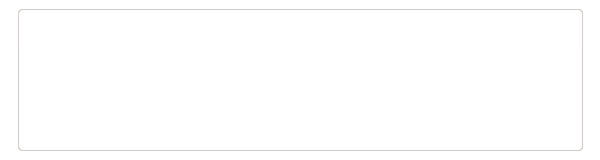
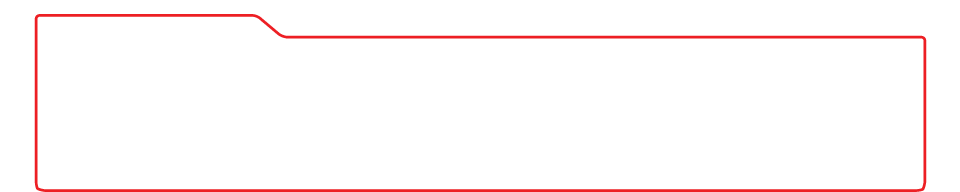
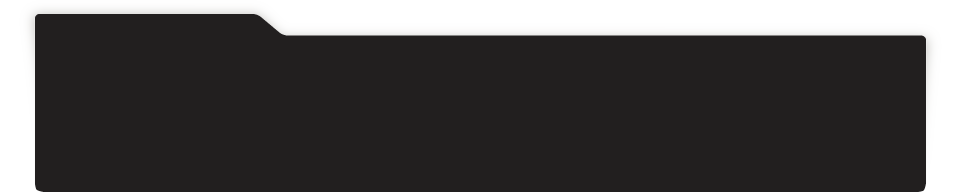
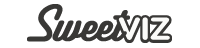
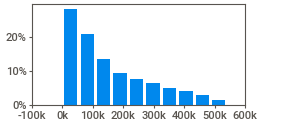
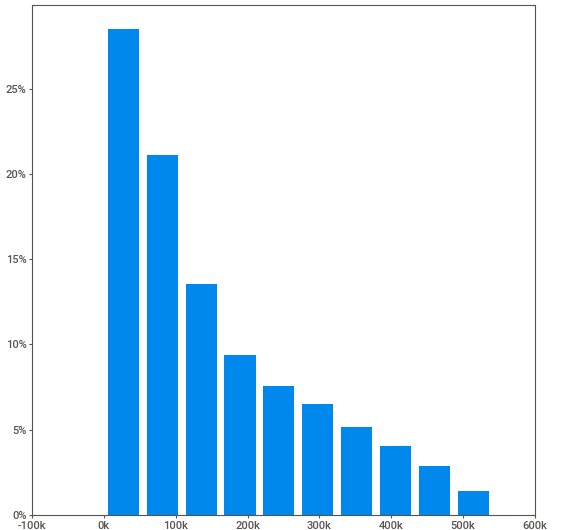
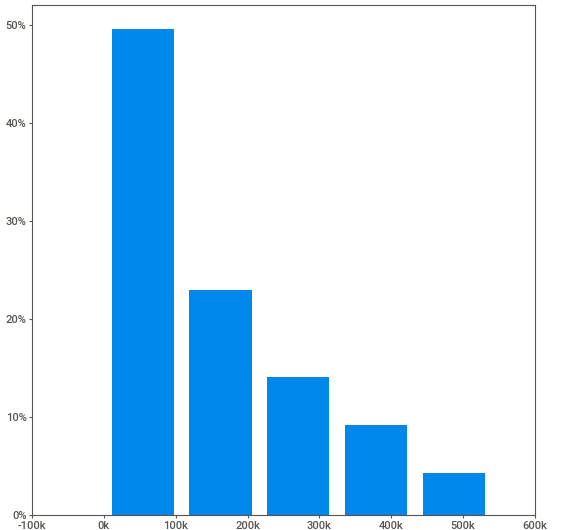
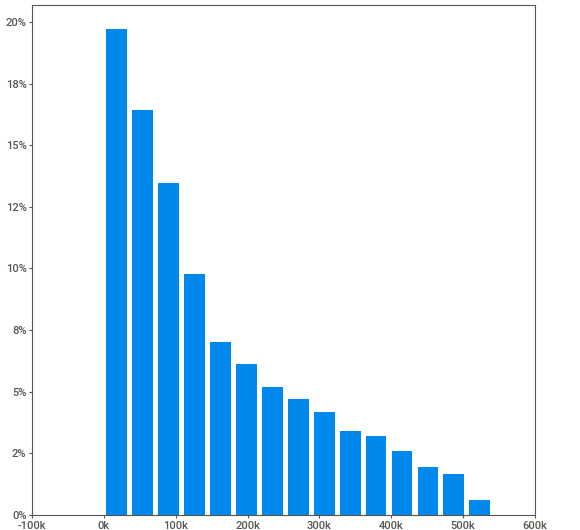
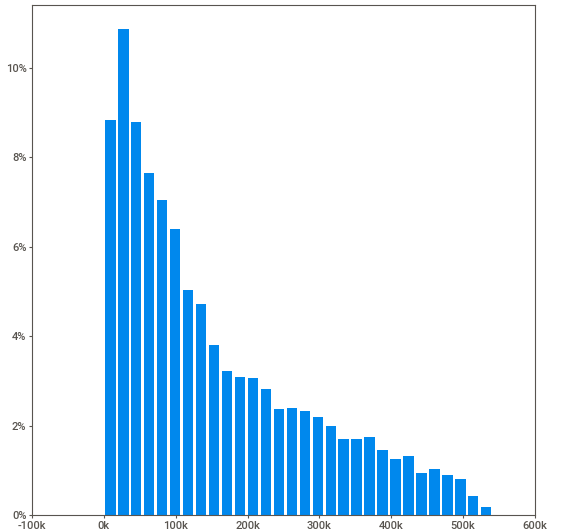
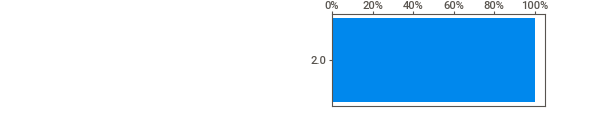
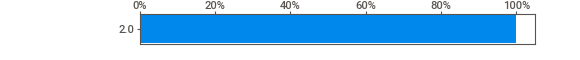
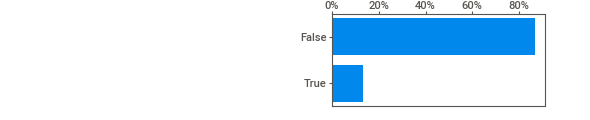
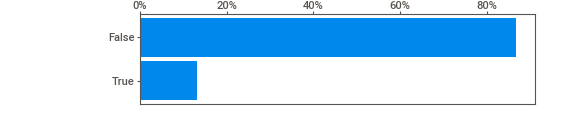
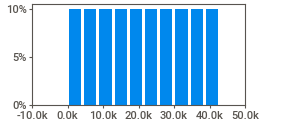
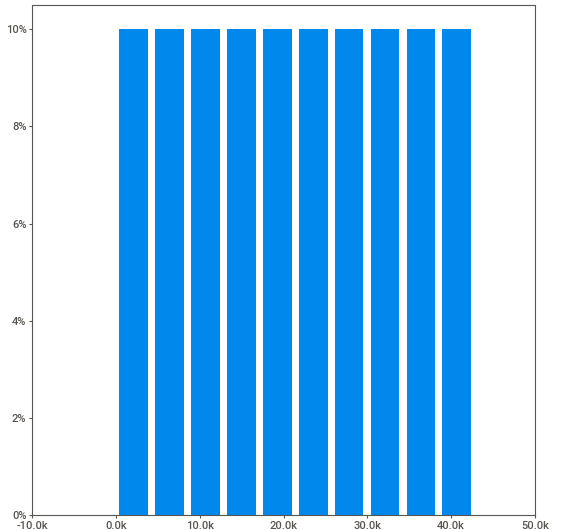
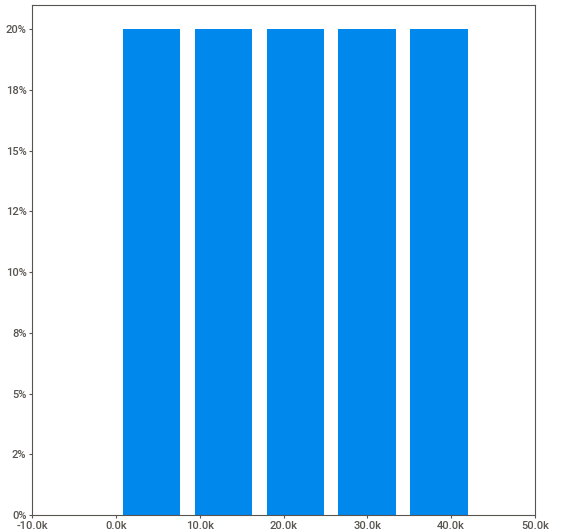
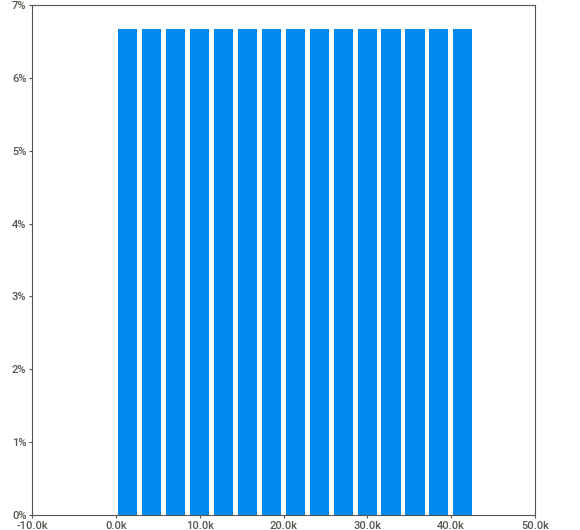
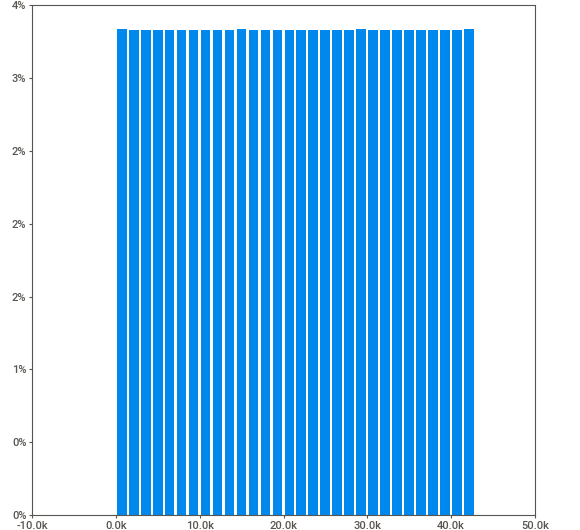
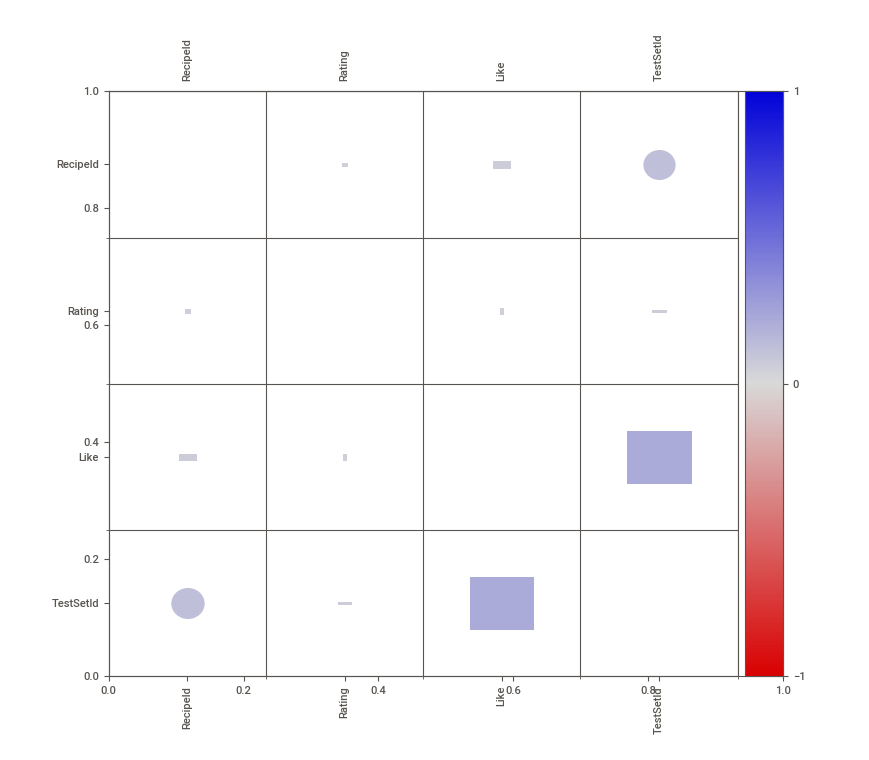
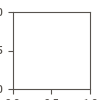

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

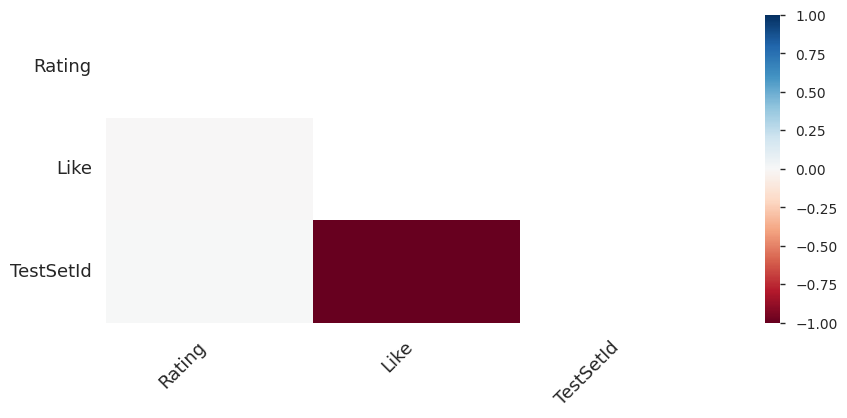

In [31]:
# We can also leverage the dataprep package to get a nice summary report
report = sv.analyze(df)
report.show_notebook()

# We can also leverage the yadata_profiling package to get a nice summary report
profile = ProfileReport(df, title="Reviews Data - Summary Report")
profile

Random Forest Classifier

In [12]:
# Step 1: Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [13]:
# Step 2: Load cleaned data
def load_cleaned_data():
    # Replace this function with your data loading and cleaning logic
    # Example assumes X contains features and y contains labels
    data = pd.read_csv('merged_diet_requests.csv')
    X = data.drop('target_column', axis=1)
    y = data['target_column']
    return X, y

X, y = load_cleaned_data()


KeyError: "['target_column'] not found in axis"